In [257]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
import numpy as np
from sklearn.metrics import roc_auc_score

In [258]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        # Define the first hidden layer
        self.hidden1 = nn.Linear(17, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Slightly reduced dropout
        
        # Define the second hidden layer
        self.hidden2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # Define the third layer
        self.hidden3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        # Define the fourth layer
        self.hidden4 = nn.Linear(32, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.relu4 = nn.ReLU()
        
        # Define the output layer
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.dropout1(self.relu1(self.batch_norm1(self.hidden1(x))))
        x = self.dropout2(self.relu2(self.batch_norm2(self.hidden2(x))))
        x = self.dropout3(self.relu3(self.batch_norm3(self.hidden3(x))))
        x = self.relu4(self.batch_norm4(self.hidden4(x)))
        x = self.sigmoid(self.output(x))
        return x


In [259]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        # Define the first hidden layer
        self.hidden1 = nn.Linear(17, 128)  # Assume input features are 17
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # Slightly reduced dropout
        
        # Define the second hidden layer
        self.hidden2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # Define the third layer
        self.hidden3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        # Define the fourth layer
        self.hidden4 = nn.Linear(32, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.relu4 = nn.ReLU()
        
        # Define the output layer
        self.output = nn.Linear(16, 1)  # Only 1 output node without sigmoid

    def forward(self, x):
        x = self.dropout1(self.relu1(self.batch_norm1(self.hidden1(x))))
        x = self.dropout2(self.relu2(self.batch_norm2(self.hidden2(x))))
        x = self.dropout3(self.relu3(self.batch_norm3(self.hidden3(x))))
        x = self.relu4(self.batch_norm4(self.hidden4(x)))
        x = self.output(x)  # No sigmoid, direct linear output
        return x

In [260]:
# Initialize the model
model = BinaryClassifier()

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [261]:
# Load the data
df = pd.read_csv('../Data/dataset83.csv')
df.drop(['Year_start', 'Year_end'], axis='columns', inplace=True)
# Convert categorical columns to numeric labels
label_encoder = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = label_encoder.fit_transform(df[column])
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        # Fill missing values with mean for numerical columns
        col_mean = df[col].mean()
        df[col] = df[col].fillna(col_mean)
    elif df[col].dtype == 'object':
        # Fill missing values with mode for categorical columns
        col_mode = df[col].mode()[0]
        df[col] = df[col].fillna(col_mode)

# Separate features and target label
X = df.drop('Sex', axis=1)
y = df['Sex']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.int64)


In [262]:
# Split data into train+val and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify=y)

# Split train+val into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)  # 0.25 x 0.8 = 0.2


In [263]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [264]:
# Define batch size
batch_size = 32

# Create data loaders
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [265]:
# For accuracy calculation
def binary_accuracy(y_pred, y_true):
    y_pred_tag = torch.round(y_pred)
    correct_results_sum = (y_pred_tag == y_true).float().sum()
    return correct_results_sum / y_true.shape[0]

In [266]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            predicted = outputs.round()
            train_correct += (predicted.squeeze() == labels).sum().item()
            train_total += labels.size(0)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / train_total)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                predicted = outputs.round()
                val_correct += (predicted.squeeze() == labels).sum().item()
                val_total += labels.size(0)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_correct/train_total:.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_correct/val_total:.4f}')

        # Step the scheduler
        scheduler.step()
        
    return train_losses, train_accuracies, val_losses, val_accuracies

# Run training
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=200
)


Epoch 1/200 - Loss: 0.6240, Accuracy: 0.6210, Val Loss: 0.5140, Val Accuracy: 0.8782
Epoch 2/200 - Loss: 0.4749, Accuracy: 0.8351, Val Loss: 0.3881, Val Accuracy: 0.9231
Epoch 3/200 - Loss: 0.3652, Accuracy: 0.8936, Val Loss: 0.2765, Val Accuracy: 0.9487
Epoch 4/200 - Loss: 0.2933, Accuracy: 0.9172, Val Loss: 0.2035, Val Accuracy: 0.9551


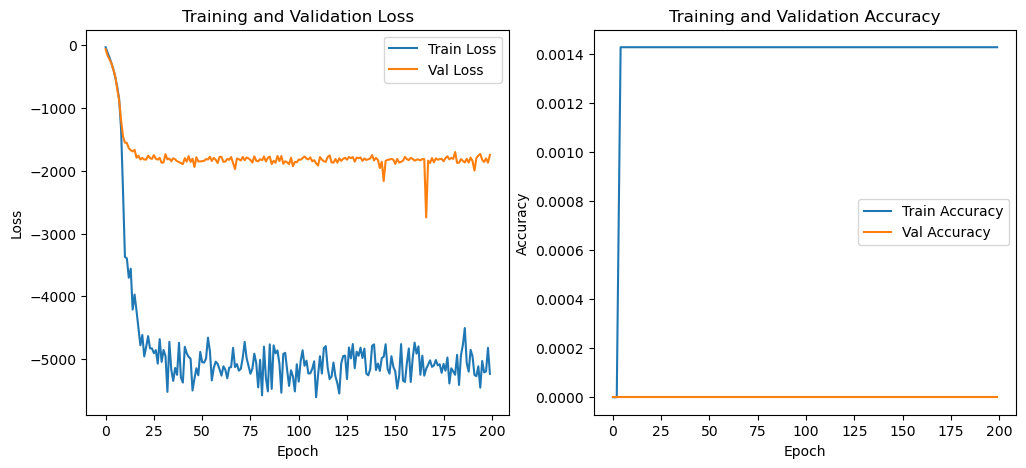

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            predicted = outputs.round()
            test_correct += (predicted.squeeze() == labels).sum().item()
            test_total += labels.size(0)
            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_correct/test_total:.4f}')

# Call to evaluate function
evaluate(model, test_loader, criterion)


Test Loss: -1820.0599, Test Accuracy: 0.0000
